<a href="https://colab.research.google.com/github/skweon-sh/yolo_2/blob/main/%EC%8B%A4%EC%8A%B5%EC%95%84%EB%8B%982.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#장치 연결 T4 확인

import gdown
import zipfile

# 파일 ID (공유 링크에서 추출한)
file_id = '10GERR8yEDAhBVtdJQI-PCor3ERy05prN'

# 다운로드될 파일의 경로 지정
output = "./data.zip"

# 공유 링크 생성
url = f'https://drive.google.com/uc?id={file_id}'

# 파일 다운로드
gdown.download(url, output, quiet=False)

# 압축 해제할 위치 지정
unzip_location = './'

# 압축 해제
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(unzip_location)

print("압축 해제 완료!")


Downloading...
From (original): https://drive.google.com/uc?id=10GERR8yEDAhBVtdJQI-PCor3ERy05prN
From (redirected): https://drive.google.com/uc?id=10GERR8yEDAhBVtdJQI-PCor3ERy05prN&confirm=t&uuid=705b1215-c588-402b-af83-d3614f5806fb
To: /content/data.zip
100%|██████████| 536M/536M [00:16<00:00, 31.7MB/s]


압축 해제 완료!


In [2]:
from google.colab import drive
import os

#체크포인트 저장할 폴더 생성

drive.mount('/content/drive') # 드라이브 연결
v_models_path = '/content/drive/MyDrive/checkpoint_models' # 저장경로 설정
if not os.path.exists(v_models_path): # 저장할 폴더 없으면
    os.makedirs(v_models_path) # 폴더 만들기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 24.8 MB/s eta 0:00:00


In [3]:
#경고뜨는거 없애기(안해도 됨)
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # 디바이스 cuda로 설정
device # 디바이스 설정 잘 되었는지 확인

'cuda'

In [11]:
#configuration
cfg = {
    "SEED": 13970515,   # 시드 설정
    "EPOCHS": 30,       # 에폭수
    "BATCH_SIZE": 8,   # 배치사이즈
    "LEARNING_RATE": 0.05,  # 학습율
    "root": "/content/datas", # 훈련이미지 주소


}

In [6]:
import random


#랜덤시드 설정
def random_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

random_seed(cfg['SEED'])

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([                #변환 정의
    ToTensorV2()
])

In [12]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
import torch.nn as nn
import torch.optim as optim

train_dataset = ImageFolder(root=cfg["root"], transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=cfg["BATCH_SIZE"], shuffle=True)


In [13]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(128, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.flatten(x)
        x = self.act4(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
model = EmotionCNN().to(device) # 모델설정 및 설정한 장치로 이동

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
#지수적으로 감소하는 스케줄러

In [16]:
import tqdm

def train_model(model, criterion, optimizer, num_epochs, train_loader):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm.tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.update(1)
            pbar.set_postfix({'Loss': running_loss / (pbar.n + 1)})
        pbar.close()
        print(f'Epoch {epoch + 1} completed, Average Loss: {running_loss / len(train_loader)}')


In [18]:
train_model(model, criterion, optimizer, 30, train_loader)


Epoch 1/30:   0%|          | 0/287 [00:00<?, ?it/s]

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

In [ ]:
#모델 훈련
model = train(model, train_loader, val_loader, criterion_seg, criterion_reg , optimizer, scheduler)

Epoch 0/30


100%|██████████| 100/100 [00:06<00:00, 15.89it/s]


Validation - Seg Loss: 0.9598797017335892, Reg Loss: 1.9427482983469964, Acc: 0.10512847900390625, R2: 0.029192694289987275
Epoch [0/30], Seg Loss: 0.9640374040603638, Reg Loss: 2.66412677526474, Acc: 0.08266668319702149, R2 : -0.15409406517185897 
Epoch 1/30


100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


Validation - Seg Loss: 0.9659930074214935, Reg Loss: 1.9779811388254165, Acc: 0.06863754272460937, R2: 0.011586552983745446
Epoch [1/30], Seg Loss: 0.9600183594226838, Reg Loss: 2.2515769386291504, Acc: 0.07228326797485352, R2 : 0.05892963751348712 
Epoch 2/30


100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


Validation - Seg Loss: 0.9619896936416626, Reg Loss: 1.8518480896949767, Acc: 0.05930755615234375, R2: 0.07461627696717676
Epoch [2/30], Seg Loss: 0.9562780386209488, Reg Loss: 2.255339080095291, Acc: 0.06481220245361329, R2 : 0.05284008134550344 
Epoch 3/30


100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


Validation - Seg Loss: 0.9592586982250214, Reg Loss: 1.875790506005287, Acc: 0.06081405639648438, R2: 0.06265204869910668
Epoch [3/30], Seg Loss: 0.9552682054042816, Reg Loss: 2.2526606595516205, Acc: 0.05821718215942383, R2 : 0.054629192519646486 
Epoch 4/30


100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


Validation - Seg Loss: 0.9858170068264007, Reg Loss: 1.8600680622458459, Acc: 0.009624481201171875, R2: 0.07050868305897351
Epoch [4/30], Seg Loss: 0.9511872154474258, Reg Loss: 2.247246450185776, Acc: 0.059155941009521484, R2 : 0.05187970829765476 
Epoch 5/30


100%|██████████| 100/100 [00:06<00:00, 16.16it/s]


Validation - Seg Loss: 0.9866000515222549, Reg Loss: 1.931320818066597, Acc: 0.01139404296875, R2: 0.034903093980516386
Epoch [5/30], Seg Loss: 0.948473202586174, Reg Loss: 2.2309495890140534, Acc: 0.05567886352539062, R2 : 0.0613902215309422 
Epoch 6/30


100%|██████████| 100/100 [00:06<00:00, 15.88it/s]


Validation - Seg Loss: 0.9949709635972976, Reg Loss: 1.894677948653698, Acc: 0.00356201171875, R2: 0.0532138285750694
Epoch [6/30], Seg Loss: 0.9460824292898178, Reg Loss: 2.226973832845688, Acc: 0.055801925659179685, R2 : 0.061480328073876045 
Epoch 7/30


100%|██████████| 100/100 [00:06<00:00, 15.93it/s]


Validation - Seg Loss: 0.9604829502105713, Reg Loss: 1.8405561766028404, Acc: 0.06609176635742188, R2: 0.08025893642567505
Epoch [7/30], Seg Loss: 0.9450854724645614, Reg Loss: 2.218781181573868, Acc: 0.055780372619628905, R2 : 0.0694885161675407 
Epoch 8/30


100%|██████████| 100/100 [00:06<00:00, 16.33it/s]


Validation - Seg Loss: 0.9719951009750366, Reg Loss: 1.9115100330114365, Acc: 0.02508758544921875, R2: 0.04480270335050507
Epoch [8/30], Seg Loss: 0.9459981501102448, Reg Loss: 2.233146803379059, Acc: 0.05843517303466797, R2 : 0.05928638718983448 
Epoch 9/30


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


Validation - Seg Loss: 0.9624243652820588, Reg Loss: 1.971940461397171, Acc: 0.06689727783203125, R2: 0.014605125007483788
Epoch [9/30], Seg Loss: 0.9434618484973908, Reg Loss: 2.224231584072113, Acc: 0.05218402862548828, R2 : 0.071719851487279 
Epoch 10/30


100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Validation - Seg Loss: 0.9521223527193069, Reg Loss: 1.8162870711088182, Acc: 0.07813308715820312, R2: 0.09238640362432138
Epoch [10/30], Seg Loss: 0.9427004939317704, Reg Loss: 2.2288425743579863, Acc: 0.056124515533447265, R2 : 0.06758709444242128 
Epoch 11/30


100%|██████████| 100/100 [00:06<00:00, 16.25it/s]


Validation - Seg Loss: 0.9500392425060272, Reg Loss: 1.8868871518969537, Acc: 0.069468994140625, R2: 0.05710696167248075
Epoch [11/30], Seg Loss: 0.9440444654226303, Reg Loss: 2.2249347388744356, Acc: 0.056048412322998044, R2 : 0.07742636703932981 
Epoch 12/30


100%|██████████| 100/100 [00:06<00:00, 16.03it/s]


Validation - Seg Loss: 0.9520720809698104, Reg Loss: 1.8007828000187873, Acc: 0.0765399169921875, R2: 0.10013401739158323
Epoch [12/30], Seg Loss: 0.9399374234676361, Reg Loss: 2.2221888303756714, Acc: 0.05064687728881836, R2 : 0.07584472983081458 
Epoch 13/30


100%|██████████| 100/100 [00:06<00:00, 15.95it/s]


Validation - Seg Loss: 0.9553934818506241, Reg Loss: 1.9156303325295447, Acc: 0.0591387939453125, R2: 0.04274375762587557
Epoch [13/30], Seg Loss: 0.9423218935728073, Reg Loss: 2.230294632911682, Acc: 0.05383869171142578, R2 : 0.07026689562084365 
Epoch 14/30


100%|██████████| 100/100 [00:06<00:00, 15.99it/s]


Validation - Seg Loss: 0.9590447747707367, Reg Loss: 1.847254160195589, Acc: 0.068228759765625, R2: 0.07691190461209618
Epoch [14/30], Seg Loss: 0.9397351878881455, Reg Loss: 2.2205740535259246, Acc: 0.05249135971069336, R2 : 0.08002038962647051 
Epoch 15/30


100%|██████████| 100/100 [00:06<00:00, 15.84it/s]


Validation - Seg Loss: 0.9602446049451828, Reg Loss: 1.783454969227314, Acc: 0.048792724609375, R2: 0.10879287819640715
Epoch [15/30], Seg Loss: 0.939084700345993, Reg Loss: 2.2228407394886016, Acc: 0.05634256362915039, R2 : 0.08133828497636131 
Epoch 16/30


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


Validation - Seg Loss: 0.956188485622406, Reg Loss: 1.8784040385484695, Acc: 0.07193023681640626, R2: 0.061346043751521084
Epoch [16/30], Seg Loss: 0.9424874395132065, Reg Loss: 2.225721046924591, Acc: 0.05286741256713867, R2 : 0.07787784930994168 
Epoch 17/30


100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


Validation - Seg Loss: 0.9543898379802704, Reg Loss: 1.871470947265625, Acc: 0.07840972900390625, R2: 0.0648105713594963
Epoch [17/30], Seg Loss: 0.9395972800254822, Reg Loss: 2.2259336602687836, Acc: 0.052242794036865235, R2 : 0.07748460157472914 
Epoch 18/30


100%|██████████| 100/100 [00:06<00:00, 15.74it/s]


Validation - Seg Loss: 0.9488603758811951, Reg Loss: 1.8516409701108933, Acc: 0.096815185546875, R2: 0.07471977254185114
Epoch [18/30], Seg Loss: 0.9404562997817993, Reg Loss: 2.2222072756290436, Acc: 0.05141525268554688, R2 : 0.0825581966729857 
Epoch 19/30


100%|██████████| 100/100 [00:06<00:00, 15.34it/s]


Validation - Seg Loss: 0.9482551538944244, Reg Loss: 1.9370484466850757, Acc: 0.09587753295898438, R2: 0.032040951180979826
Epoch [19/30], Seg Loss: 0.940004700422287, Reg Loss: 2.2204796946048737, Acc: 0.052138233184814455, R2 : 0.08597654703587088 
Epoch 20/30


100%|██████████| 100/100 [00:06<00:00, 15.30it/s]


Validation - Seg Loss: 0.9545940113067627, Reg Loss: 1.941698534488678, Acc: 0.0779913330078125, R2: 0.029717266145686372
Epoch [20/30], Seg Loss: 0.9395748901367188, Reg Loss: 2.220486001968384, Acc: 0.053425445556640624, R2 : 0.08564506874838729 
Epoch 21/30


100%|██████████| 100/100 [00:06<00:00, 15.38it/s]


Validation - Seg Loss: 0.9531247997283936, Reg Loss: 1.848991256058216, Acc: 0.0740380859375, R2: 0.07604385091784915
Epoch [21/30], Seg Loss: 0.9389587408304214, Reg Loss: 2.219594190120697, Acc: 0.0521422004699707, R2 : 0.08498116911499498 
Epoch 22/30


100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


Validation - Seg Loss: 0.9552507203817368, Reg Loss: 1.9042991623282433, Acc: 0.05879776000976562, R2: 0.04840603719147307
Epoch [22/30], Seg Loss: 0.9334668350219727, Reg Loss: 2.2232535886764526, Acc: 0.05308727264404297, R2 : 0.07996190872236464 
Epoch 23/30


100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


Validation - Seg Loss: 0.9544666194915772, Reg Loss: 1.9527379308640958, Acc: 0.08083572387695312, R2: 0.024200785642259803
Epoch [23/30], Seg Loss: 0.939118133187294, Reg Loss: 2.2276567137241363, Acc: 0.052876491546630856, R2 : 0.07995384305544884 
Epoch 24/30


100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Validation - Seg Loss: 0.9492840379476547, Reg Loss: 1.8998845919966698, Acc: 0.08977462768554688, R2: 0.05061203062678221
Epoch [24/30], Seg Loss: 0.9383747434616089, Reg Loss: 2.223111779689789, Acc: 0.05576503753662109, R2 : 0.07931859323004342 
Epoch 25/30


100%|██████████| 100/100 [00:06<00:00, 15.42it/s]


Validation - Seg Loss: 0.9554819959402084, Reg Loss: 1.915003919005394, Acc: 0.07197723388671876, R2: 0.043056788282983094
Epoch [25/30], Seg Loss: 0.9392832511663437, Reg Loss: 2.222736631631851, Acc: 0.05370391845703125, R2 : 0.08275809244386645 
Epoch 26/30


100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Validation - Seg Loss: 0.9482165706157685, Reg Loss: 1.8966739377379418, Acc: 0.09197067260742188, R2: 0.05221642164270124
Epoch [26/30], Seg Loss: 0.9337701189517975, Reg Loss: 2.222338783740997, Acc: 0.05533924102783203, R2 : 0.08045394039977494 
Epoch 27/30


100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Validation - Seg Loss: 0.9475365722179413, Reg Loss: 1.8952081882953644, Acc: 0.07338027954101563, R2: 0.052948871672999887
Epoch [27/30], Seg Loss: 0.9382904905080796, Reg Loss: 2.222073985338211, Acc: 0.05181978225708008, R2 : 0.08305659411999278 
Epoch 28/30


100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


Validation - Seg Loss: 0.9481754523515701, Reg Loss: 1.8968656119704246, Acc: 0.08044845581054688, R2: 0.052120650797559565
Epoch [28/30], Seg Loss: 0.934102772474289, Reg Loss: 2.2195316839218138, Acc: 0.05561370849609375, R2 : 0.08633167230834782 
Epoch 29/30


100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Validation - Seg Loss: 0.9494602942466736, Reg Loss: 1.8707577168941498, Acc: 0.06986419677734375, R2: 0.06516697084700662
Epoch [29/30], Seg Loss: 0.9361253899335861, Reg Loss: 2.2189192855358124, Acc: 0.0544696044921875, R2 : 0.08847461932897716 


In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize(model, dataloader, num_images=5):
    model.eval()
    images_processed = 0

    with torch.no_grad():
        for images, (labels_segmentation, labels_regression) in dataloader:
            if images_processed >= num_images:
                break

            images = images.to(device) #장치로 이동
            labels_segmentation = labels_segmentation.to(device)
            labels_regression = labels_regression.to(device)
            outputs_segmentation, outputs_regression = model(images) # 결과값 추출
            predicted_labels_segmentation = outputs_segmentation.argmax(1) # 가장 확률이 높은 것 ㅓㄴ택
            predicted_labels_regression = outputs_regression.squeeze()

            fig, axes = plt.subplots(1, 5, figsize=(25, 5))
            axes[0].imshow(images[0].cpu().squeeze().permute(1, 2, 0)) # 표시
            axes[0].set_title("Original Image")
            axes[1].imshow(labels_segmentation[0].cpu().squeeze(), cmap='Pastel1')
            axes[1].set_title("Segmentation Label")
            axes[2].imshow(predicted_labels_segmentation[0].cpu().numpy(), cmap='Pastel1')
            axes[2].set_title("Segmentation Prediction")
            axes[3].imshow(labels_regression[0].cpu().squeeze(), cmap='viridis')
            axes[3].set_title("Regression Label")
            axes[4].imshow(predicted_labels_regression.cpu().numpy(), cmap='viridis')
            axes[4].set_title("Regression Prediction")
            images_processed += 1


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_regression(model, data_loader, num_samples_per_image=30, num_samples_total=1000):
    # 모델을 평가 모드로 설정
    model.eval()

    # 그라디언트 계산 비활성화
    with torch.no_grad():
        # 실제 및 예측 값을 저장할 리스트 초기화
        true_values = []
        predicted_values = []

        # 데이터 로더에서 미니 배치 추출
        for image, (_, label_regression) in data_loader:
            # 이미지를 장치로 이동
            image = image.to(device)
            label_regression = label_regression.to(device)

            # 모델을 통해 예측 수행
            _, output_regression = model(image)

            # 라벨의 높이와 너비 가져오기
            _, height, width = label_regression.shape

            # 각 이미지에서 임의의 픽셀 샘플 선택
            random_indices = np.random.choice(height * width, num_samples_per_image, replace=False)

            # 실제 및 예측 값을 1차원 배열로 변환하고 선택된 픽셀 인덱스에 대해 선택
            true_masked = label_regression.view(-1)[random_indices].cpu().numpy()
            pred_masked = output_regression.view(-1)[random_indices].cpu().numpy()

            # 실제 및 예측 값에 샘플 추가
            true_values.extend(true_masked)
            predicted_values.extend(pred_masked)

            # 샘플 수가 총량에 도달하면 루프 종료
            if len(true_values) >= num_samples_total:
                break

        # 최대 총 샘플 수에 맞게 값을 자름
        true_values = true_values[:num_samples_total]
        predicted_values = predicted_values[:num_samples_total]

        # 실제와 예측된 픽셀 값을 나타내는 산점도 생성
        plt.figure(figsize=(8, 8))
        plt.scatter(true_values, predicted_values, alpha=0.5)
        plt.xlabel("Actual Pixel Values")  # x축 라벨
        plt.ylabel("Predicted Pixel Values")  # y축 라벨
        plt.title("Scatter Plot of Actual vs Predicted Pixel Values")  # 그래프 제목
        plt.grid(True)  # 그리드 표시
        plt.show()  # 그래프 표시

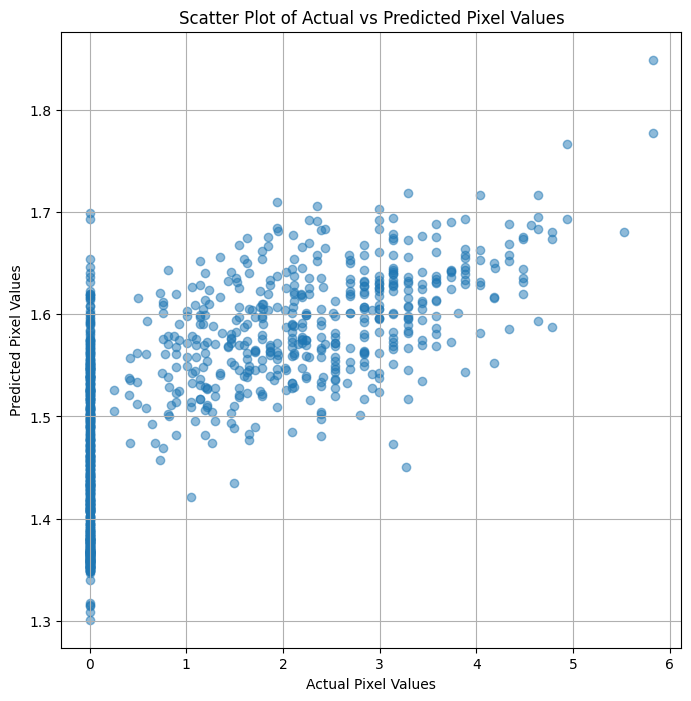

In [ ]:
plot_regression(model, val_loader)

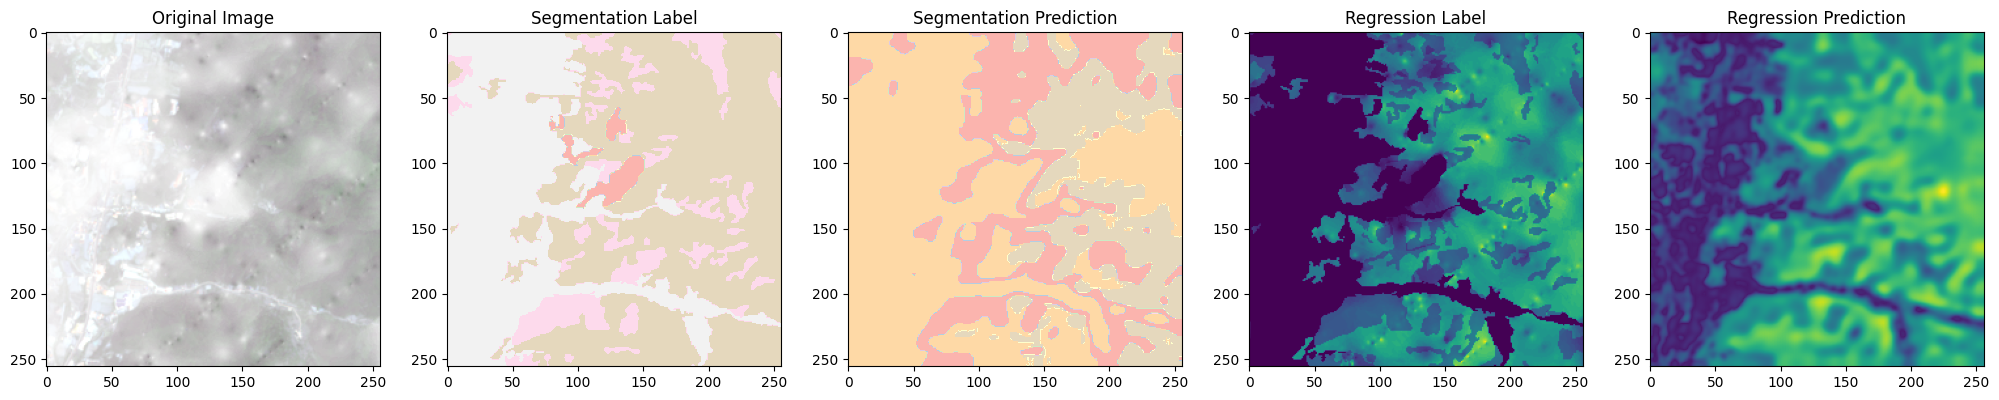

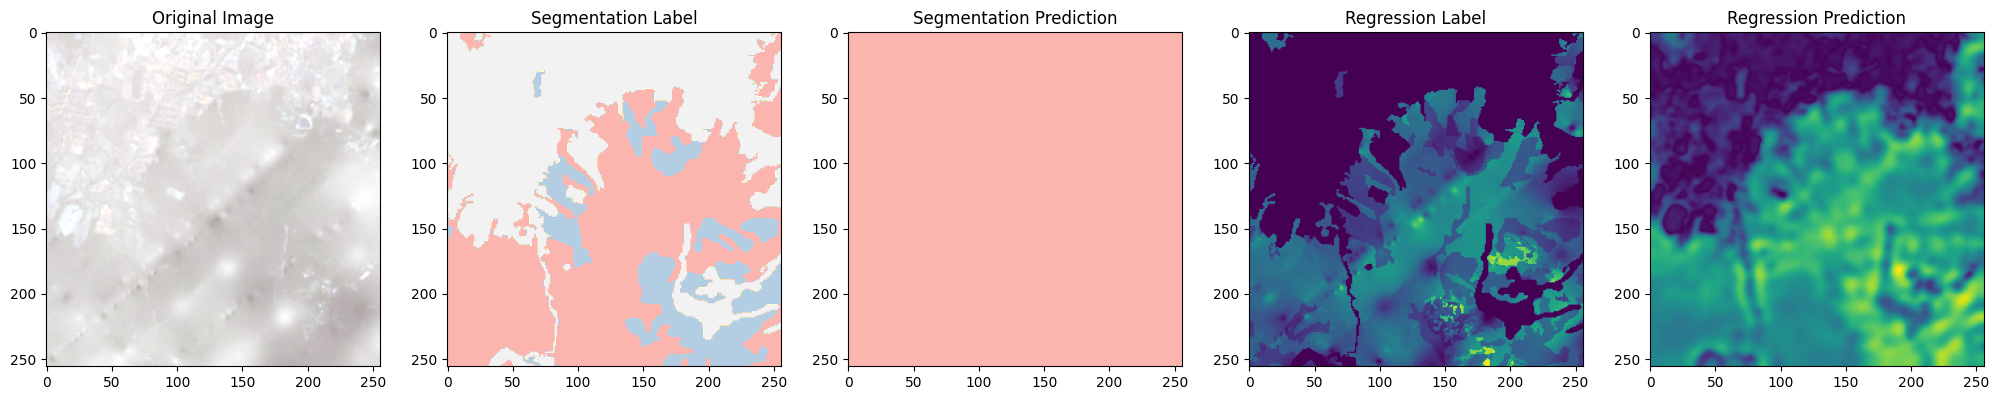

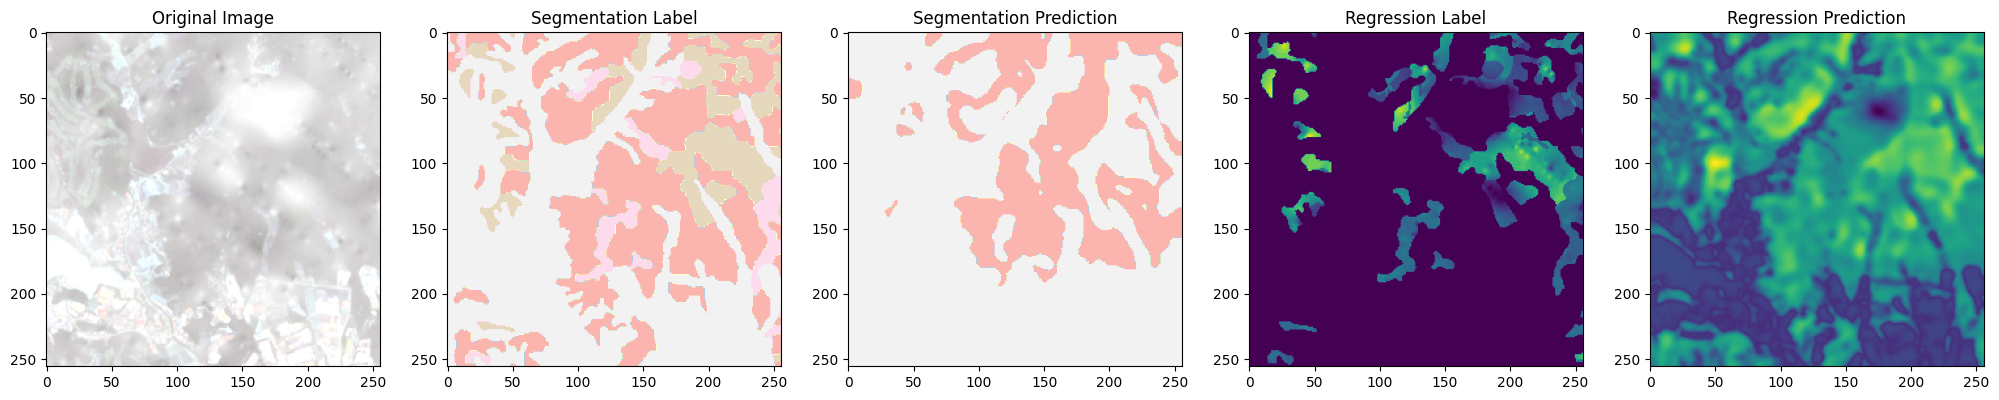

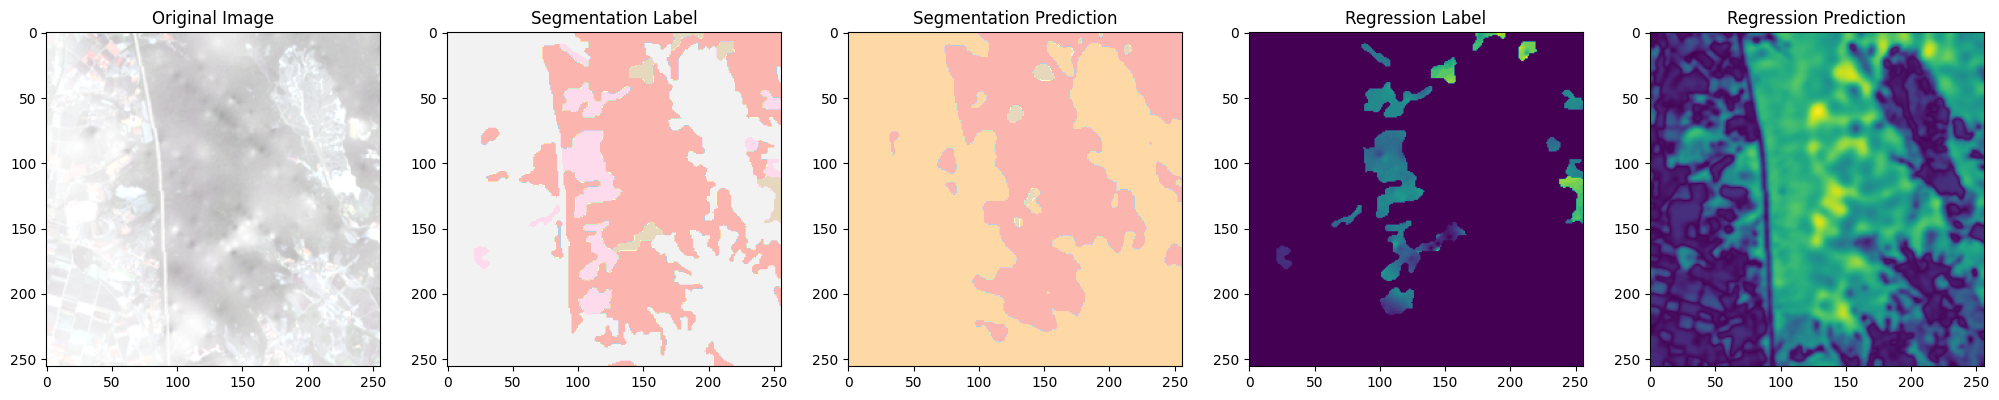

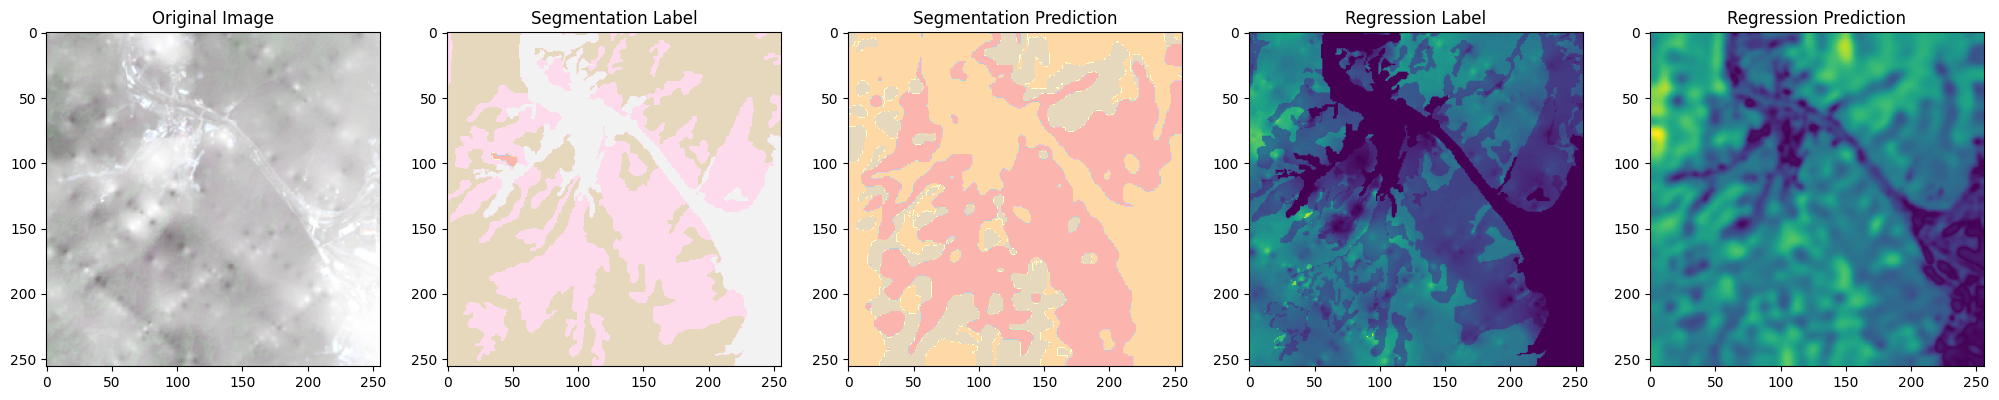

In [ ]:
visualize(model, val_loader,  num_images=5)


In [ ]:
#체크포인트 부터 훈련할 때 사용할 코드


checkpoint_path = '/content/drive/MyDrive/checkpoint_models/CHECKPOINT_FILE_NAME.pth'

checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/checkpoint_models/CHECKPOINT_FILE_NAME.pth'

In [ ]:
train(model, train_loader, val_loader, criterion_segmentation, criterion_regression, optimizer, scheduler, start_epoch=epoch)